In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_boston

In [2]:
house = load_boston()
house.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [3]:
house_df = pd.DataFrame(data=house.data, columns=house.feature_names)
house_df['PRICE'] = house.target
house_df.to_pickle('dataset/house_df.pkl')

In [4]:
house_df = pd.read_pickle('dataset/house_df.pkl')
house_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE'], axis=1)
# X_data = house_df[['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', \
#                    'LSTAT','RAD']]

X_train, X_test, y_train, y_test = \
train_test_split(X_data,y_target,test_size=0.3,random_state=1)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print('MSE : {:.3f}, RMSE : {:.3f}, R2 score : {:.3f}'.format(mse,rmse,r2))
print('절편 값 : ', lr.intercept_)
print('회귀 계수값 : ',np.round(lr.coef_, 1))

MSE : 19.831, RMSE : 4.453, R2 score : 0.784
절편 값 :  46.39649387182395
회귀 계수값 :  [ -0.1   0.1   0.1   2.4 -21.5   2.8   0.   -1.5   0.3  -0.   -1.    0.
  -0.6]


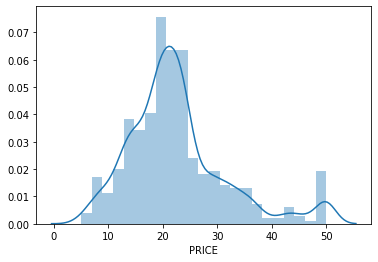

In [9]:
import warnings
warnings.filterwarnings('ignore')
sns.distplot(house_df.PRICE)

In [ ]:
# 데이터왜곡: 데이터가 정규성에서 벗어난다는 의미
# 로그 변환을 통해 데이터 왜곡을 완화시킬 수 있다.

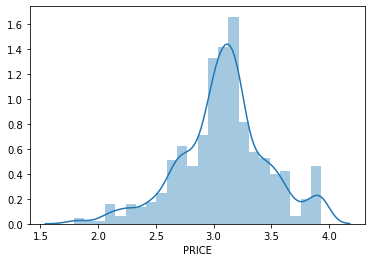

In [10]:
#종속변수를 로그변환하여 데이터의 왜곡을 잡아주고, 정규성을 확보
sns.distplot(np.log1p(house_df.PRICE))

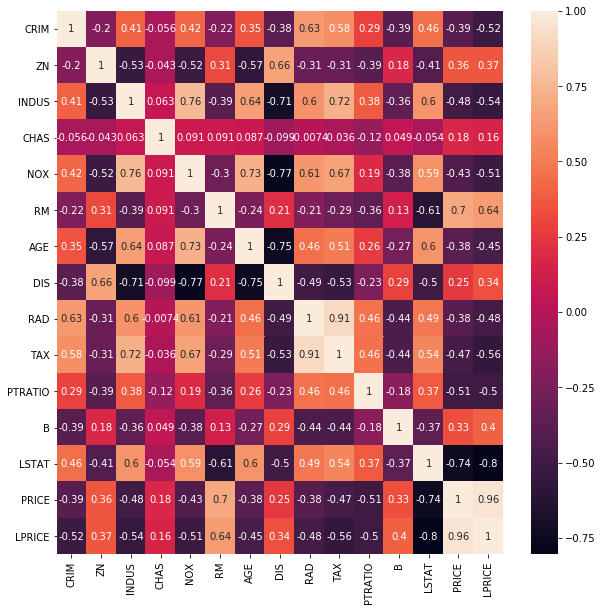

In [12]:
house_df['LPRICE'] = np.log1p(house_df.PRICE)
plt.figure(figsize=(10,10))
sns.heatmap(house_df.corr(),annot=True)

In [13]:
# 종속변수 로그 변환 및 독립변수 선택
import seaborn as sns
# sns.distplot(house_df.PRICE)
X=house_df[['RM', 'INDUS', 'NOX', 'PTRATIO', 'LSTAT','RAD']]
y=house_df['PRICE']
y_log = np.log1p(house_df['PRICE'])

X_train, X_test, y_train, y_test = \
train_test_split(X,y_log,test_size=0.3,random_state=1)

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# 로그변환된 것을 환원
y_exp = np.expm1(y_test)
y_pexp = np.expm1(y_pred)

mse = mean_squared_error(y_exp, y_pexp)
rmse = np.sqrt(mse)

r2 = r2_score(y_exp,y_pexp)
print('MSE : {:.3f}, RMSE : {:.3f}, R2 score : {:.3f}'.format(mse,rmse,r2))
print('절편 값 : ', lr.intercept_)
print('회귀 계수값 : ',np.round(lr.coef_, 1))

MSE : 26.286, RMSE : 5.127, R2 score : 0.713
절편 값 :  3.95274293214216
회귀 계수값 :  [ 0.1  0.  -0.5 -0.  -0.   0. ]


In [14]:
# 교차검증
from sklearn.model_selection import cross_val_score

y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE'], axis=1)

lr = LinearRegression()

# neg: 마이너스(-) 처리를 의미
# ex) mse 7.5, mse 100 둘 중에 mse 7.5가 더 좋은 값.
# But, cross_val_score는 높은 값일수록 좋다고 판단, 
# 그래서 mse 100이 더 좋은 값으로 판단한다. 이를 방지하기 위해,
# 'scoring = neg ~'를 사용하여 -7.5, -100으로 만들어줘서, 
# mse 7.5값이 더 좋은 값으로 판단하도록 만들어준다
neg_mse_scores = cross_val_score(lr, X_data, y_target, \
                                 scoring='neg_mean_squared_error', cv=5)

# 마이너스 처리한 걸 다시 돌려주어야하기때문에 -1 곱함
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores,2))
print('5 folds의 평균 RMSE:{:.4f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [ -1.06  -4.08  -6.55 -14.29 -11.54]
5 folds의 개별 RMSE scores: [1.03 2.02 2.56 3.78 3.4 ]
5 folds의 평균 RMSE:2.5576


### 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
- 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 필요가 있음
- 선형 모형의 비용함수는 RSS(실제 값과 예측값의 차이)를 최소화하는 것만 고려한 결과 테스트 데이터 세트 예측 성능 저하 초래
- RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이루게 해야 함(최적모델을 위한 Cost 함수 구성요소 = 학습데이터 잔차 오류 최소화 + 회귀계수 크기 제어)
- 회귀 계수 값의 크기를 조절하기 위하여 비용 함수에 알파 값으로 패널티를 부여해 과적합을 개선하는 방식을 규제라고 함
alpha값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있으며 alpha값을 작게 하면 회귀 계수 W의 값이 커져도 어느정도 상쇄가 가능하므로 학습데이터 적합을 더 개선
- 비용함수에 alpha값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제라고 한다.
- 규제는 크게 L2 방식과 L1 방식으로 구분되며 전자를 적용한 회귀를 릿지, 후자를 적용한 것이 라쏘임
- L2는 W의 제곱에 패널티를 부여하며 L1은 W의 절댓값에 패널티 부여
- 엘리스틱넷 회귀는 L2 규제와 L1 규제를 결합한 회귀

In [23]:
from IPython.display import Image

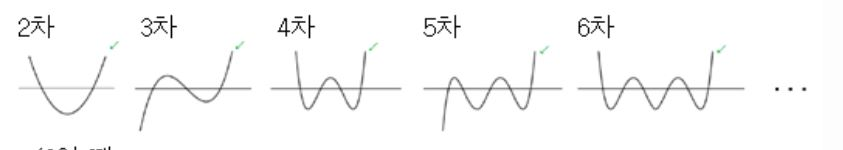

In [24]:
Image("C:/Users/user/Desktop/caba_2015_필기/day44/고차방정식.jpg")

- 회귀계수가 커지면 학습 데이터에만 너무 적합돼(과적합) 평가용 데이터에서는 형편없는 예측성능을 보인다.
- 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야 한다.
- 비용함수에 Alpha값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regularization)라고 한다.

### 릿지 회귀
- alpha L2 규제 계수에 해당
- 릿지 회귀는 alpha 값이 커질수록 회귀 계수 값을 작게 만든다.
- 릿지 회귀는 회귀 계수를 작게 만들지만, 0으로 만들지는 않는다.

In [15]:
# 릿지 회귀
from sklearn.linear_model import Ridge

y_target = house_df['PRICE']
X_data = house_df.drop(['PRICE'],axis=1)
# 10은 릿지 회귀의 alpha L2 규제 계수에 해당
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target,\
                                scoring="neg_mean_squared_error"\
                                ,cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('5 folds의 개별 Negative MSE scores :', np.round(neg_mse_scores,3))
print('5 folds의 개별 RMSE scores :', np.round(rmse_scores,3))
print('5 folds의 평균 RMSE scores : {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores : [ -2.946  -8.763 -11.529 -32.437 -10.377]
5 folds의 개별 RMSE scores : [1.716 2.96  3.395 5.695 3.221]
5 folds의 평균 RMSE scores : 3.398


In [17]:
alphas = [0, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, \
                                    scoring='neg_mean_squared_error', cv=5)
    avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {}일 때 5 folds의 평균 RMSE :{:.4f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE :2.5576
alpha 0.1일 때 5 folds의 평균 RMSE :2.5608
alpha 1일 때 5 folds의 평균 RMSE :2.6147
alpha 10일 때 5 folds의 평균 RMSE :3.3977
alpha 100일 때 5 folds의 평균 RMSE :4.8170


In [33]:
ridge.coef_

array([-6.88072705e-02,  4.93788310e-02, -5.04155661e-02,  5.55192811e-01,
       -2.22767448e-01,  2.11999931e+00,  1.43828385e-03, -1.02568313e+00,
        2.67296186e-01, -1.32462147e-02, -7.18311340e-01,  7.84680735e-03,
       -5.46929468e-01,  3.69185320e+00])

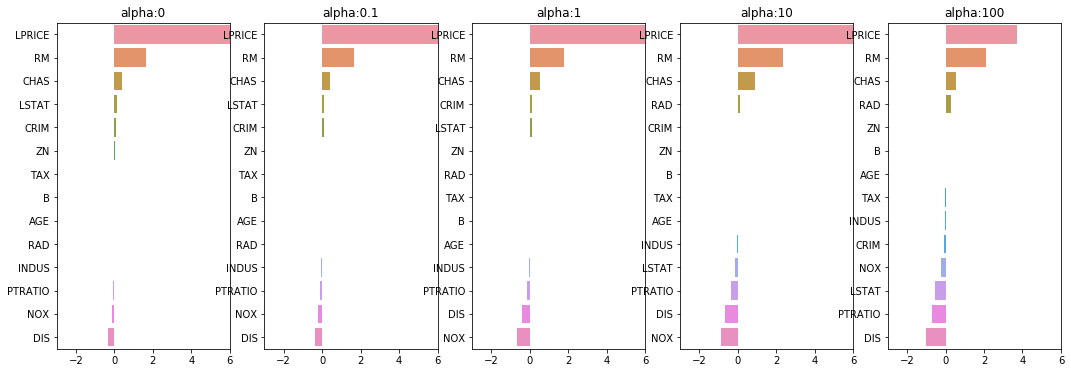

In [18]:
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data,y_target)
    
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index,ax=axs[pos])

In [ ]:
# 그래프를 보니, 회귀계수들이 알파가 올라갈수록 점점 줄어든다

In [26]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column ='alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column,ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
LPRICE,23.780849,23.634189,22.414891,14.978288,3.691853
RM,1.665720,1.677817,1.780097,2.346626,2.119999
CHAS,0.389320,0.402147,0.502316,0.910345,0.555193
LSTAT,0.123375,0.119275,0.084767,-0.134681,-0.546929
CRIM,0.114185,0.112817,0.101601,0.034193,-0.068807
ZN,0.018940,0.019117,0.020634,0.030605,0.049379
TAX,0.001702,0.001612,0.000844,-0.004202,-0.013246
B,-0.000137,-0.000079,0.000422,0.003592,0.007847
AGE,-0.003271,-0.003248,-0.003336,-0.005486,0.001438
RAD,-0.014697,-0.012709,0.003106,0.096451,0.267296


In [27]:
# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고, 회귀 계수값들을 DataFrame으로 반환
from sklearn.linear_model import Lasso, ElasticNet
def get_linear_reg_eval(model_name,params=None, X_data_n=None, \
                       y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose:print('###### ', model_name , '######')
    for param in params:
        if model_name == 'Ridge':model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet':model = ElasticNet(alpha=param,\
                                                          l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,y_target_n,\
                                        scoring='neg_mean_squared_error',cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {}일 때 5 폴드 세트의 평균 RMSE:{:4f}'.format(param,avg_rmse))
        model.fit(X_data,y_target)
        coeff = pd.Series(data = model.coef_,index=X_data.columns)
        colname='alpha:'+str(param)
        coeff_df[colname] = coeff

    return coeff_df

### 라쏘 회귀
- W의 절댓값에 페널티를 부여하는 L1 규제를 선형회귀에 적용한 것
- L2 규제가 회귀계수를 감소시킨다면(0으로는 만들지 않음), L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거
- 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가짐

In [28]:
# 라쏘 회귀
lasso_alphas = [0.07,0.1,0.5,1.3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas,\
                                    X_data_n=X_data, y_target_n=y_target)
coeff_lasso_df

######  Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE:2.556405
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:2.607130
alpha 0.5일 때 5 폴드 세트의 평균 RMSE:3.945799
alpha 1.3일 때 5 폴드 세트의 평균 RMSE:5.845140


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
CRIM,0.098066,0.091182,0.001545,-0.051638
ZN,0.021612,0.022594,0.035301,0.048850
INDUS,-0.025406,-0.023712,-0.005518,-0.000000
CHAS,0.000000,0.000000,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000
RM,1.587536,1.559277,1.311474,0.018113
AGE,-0.000157,0.000323,0.008583,0.031350
DIS,-0.366207,-0.380765,-0.508078,-0.511309
RAD,0.011763,0.021109,0.141641,0.255433
TAX,0.000174,-0.000337,-0.007229,-0.014981


In [ ]:
# 회귀계수가 0인 피처는 회귀 식에서 제외된다. (피처 선택의 특성)

In [ ]:
# 엘라스틱넷 회귀
- L2 규제와 L1규제를 결합한 회귀 모델

In [29]:
# 엘라스틱넷 회귀
elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas,\
                                      X_data_n=X_data, y_target_n=y_target)
coeff_elastic_df

######  ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE:3.379259
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:3.668586
alpha 0.5일 때 5 폴드 세트의 평균 RMSE:4.972744
alpha 1일 때 5 폴드 세트의 평균 RMSE:5.456735
alpha 3일 때 5 폴드 세트의 평균 RMSE:6.068122


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
CRIM,0.024462,0.004000,-0.061167,-0.065450,-0.019058
ZN,0.032257,0.035460,0.048646,0.050849,0.038268
INDUS,-0.034379,-0.033694,-0.021706,-0.000000,-0.000000
CHAS,0.374820,0.251174,0.000000,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
RM,2.298832,2.367582,1.720480,0.894794,0.000000
AGE,-0.004187,-0.003487,0.008121,0.020296,0.043446
DIS,-0.675369,-0.743597,-0.867634,-0.695814,-0.031208
RAD,0.111572,0.142060,0.260663,0.277210,0.146846
TAX,-0.005268,-0.006936,-0.013855,-0.015551,-0.011417


In [30]:
# 선형 회귀 모형을 위한 데이터 변환
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
def get_scaled_data(method=None, p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree,include_bias=False).\
        fit_transform(scaled_data)
    return scaled_data

In [32]:
alphas=[0.1,1,10,100]
scale_methods =[(None,None),('Standard',None),('Standard',2),
               ('MinMax',None),('MinMax',2),('Log',None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0],
                                   p_degree=scale_method[1],
                                   input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0],\
                                                        scale_method[1]))
    get_linear_reg_eval('Ridge',params=alphas,X_data_n=X_data_scaled, \
                        y_target_n=y_target,verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:2.560751
alpha 1일 때 5 폴드 세트의 평균 RMSE:2.614651
alpha 10일 때 5 폴드 세트의 평균 RMSE:3.397696
alpha 100일 때 5 폴드 세트의 평균 RMSE:4.816984

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:2.558000
alpha 1일 때 5 폴드 세트의 평균 RMSE:2.561691
alpha 10일 때 5 폴드 세트의 평균 RMSE:2.626306
alpha 100일 때 5 폴드 세트의 평균 RMSE:3.320848

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:0.966048
alpha 1일 때 5 폴드 세트의 평균 RMSE:1.107439
alpha 10일 때 5 폴드 세트의 평균 RMSE:1.892211
alpha 100일 때 5 폴드 세트의 평균 RMSE:3.203167

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:2.580136
alpha 1일 때 5 폴드 세트의 평균 RMSE:2.846153
alpha 10일 때 5 폴드 세트의 평균 RMSE:4.191559
alpha 100일 때 5 폴드 세트의 평균 RMSE:7.075139

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:0.872126
alpha 1일 때 5 폴드 세트의 평균 RMSE:1.334568
alpha 10일 때 5 폴드 세트의 평균 RMSE:2.563727
alpha 100일 때 5 폴드 세트의 평균 RMSE:5.026173

## 변환 유형:Log, Polynomial Degree:N